In [1]:
import pandas as pd

sdss_df = pd.read_csv('./data/Skyserver_SQL2_27_2018 6_51_39 PM.csv', skiprows=1)
sdss_df.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1237648704577142822,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3722360139651588096,STAR,-0.000009,3306,54922,491
1,1237648704577142859,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,363814405953054720,STAR,-0.000055,323,51615,541
2,1237648704577208477,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,323274319570429952,GALAXY,0.123111,287,52023,513
3,1237648704577273907,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3722365362331820032,STAR,-0.000111,3306,54922,510
4,1237648704577273909,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3722365912087633920,STAR,0.000590,3306,54922,512


In [2]:
sdss_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
objid        10000 non-null int64
ra           10000 non-null float64
dec          10000 non-null float64
u            10000 non-null float64
g            10000 non-null float64
r            10000 non-null float64
i            10000 non-null float64
z            10000 non-null float64
run          10000 non-null int64
rerun        10000 non-null int64
camcol       10000 non-null int64
field        10000 non-null int64
specobjid    10000 non-null uint64
class        10000 non-null object
redshift     10000 non-null float64
plate        10000 non-null int64
mjd          10000 non-null int64
fiberid      10000 non-null int64
dtypes: float64(8), int64(8), object(1), uint64(1)
memory usage: 1.4+ MB


In [3]:
sdss_df.drop(['objid', 'run', 'rerun', 'camcol', 'field', 'specobjid'], axis=1, inplace=True)
sdss_df.head(1)

,ra,dec,u,g,r,i,z,class,redshift,plate,mjd,fiberid
0,183.531326,0.089693,19.47406,17.0424,15.94699,15.50342,15.22531,STAR,-0.000009,3306,54922,491


In [4]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(sdss_df['class'])


y_encoded = y_encoded.reshape(-1, 1)
y_encoded

array([[2],
       [2],
       [0],
       ...,
       [2],
       [0],
       [0]])

In [5]:
enc = OneHotEncoder()
enc.fit(y_encoded)
y_encoded = enc.transform(y_encoded)
y_encoded = y_encoded.toarray().tolist()

In [6]:
sdss_df.drop(['class'], axis=1, inplace=True)
sdss_df.head()

,ra,dec,u,g,r,i,z,redshift,plate,mjd,fiberid
0,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,-0.000009,3306,54922,491
1,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,-0.000055,323,51615,541
2,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,0.123111,287,52023,513
3,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,-0.000111,3306,54922,510
4,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,0.000590,3306,54922,512


In [22]:
scaler = MinMaxScaler(feature_range=(-1, 1))
sdss = scaler.fit_transform(sdss_df).tolist()

In [8]:
import numpy as np

def stitch(inputs, target):
    series_inputs = pd.Series(inputs)
    series_target = pd.Series(target)
    df = pd.DataFrame({'inputs': series_inputs, 'target': series_target})
    return df.values.tolist()

def unstitch(data):
    df = pd.DataFrame(data)
    return df[0].values.tolist(), df[1].values.tolist()

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

class Net(nn.Module):
    def __init__(self, dropout=False, weightDecay=0):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(11, 11) # 2 Input noses, 50 in middle layers
        self.do1 = nn.Dropout(p=0.2)
        self.rl1 = nn.Sigmoid()
        self.fc2 = nn.Linear(11, 3)
        self.smout = nn.Softmax(dim=1)      
        
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=0.01, weight_decay=0)
        self.dropout=dropout
        
        self.cuda()
        
        self.trainOverTimeAccuracy = []
        self.trainOverTimeLoss = []
        self.testOverTimeAccuracy = []
        self.testOverTimeLoss = []
    
    def forward(self, x):
        x = self.fc1(x)
        if self.dropout:
            x = self.do1(x)
        x = self.rl1(x)
        x = self.fc2(x)
        x = self.smout(x)
        return x
    
    def log(self, epoch, train, test):
        if epoch % REPORT_RATE == 0:
            self.trainOverTimeAccuracy.append(self.accuracy(train))
            #self.trainOverTimeLoss.append(self.loss(train))
            self.testOverTimeAccuracy.append(self.accuracy(test))
            #self.testOverTimeLoss.append(self.loss(test))
            
    def epochTrain(self, inputs, labels):
        self.optimizer.zero_grad()
        outputs = self(inputs)
        self.loss = self.criterion(outputs, torch.max(labels, 1)[1])
        self.loss.backward()    
        self.optimizer.step()

        
    def train(self, numEpochs, train_set, train, test):
        inputs, labels = unstitch(train_set)
        
        inputs = Variable(torch.FloatTensor(inputs).cuda())
        labels = Variable(torch.FloatTensor(labels).cuda())

        for epoch in range(numEpochs):
            self.epochTrain(inputs, labels)
            self.log(epoch, train, test)
                
    def activetrain(self, activeUpdateRate, batchSize, numEpochs, train, test):
        trainings = int(numEpochs/activeUpdateRate)
        currentEpoch = 0

        for i in range(trainings):
            activecriterion = nn.CrossEntropyLoss(reduction='none')
            
            inputs, labels = unstitch(train)
            
            inputs = Variable(torch.FloatTensor(inputs).cuda())
            labels = Variable(torch.FloatTensor(labels).cuda())
            
            outputs = self(inputs)

            loss = activecriterion(outputs, torch.max(labels, 1)[1]).detach().cpu().numpy()
            sortIndexs = np.argsort(loss)[::-1]
            dynamicTrainSet = np.array(np.copy(train))[sortIndexs]
            dynamicTrainSet = dynamicTrainSet[0:batchSize]

            inputs, labels = unstitch(dynamicTrainSet)
        
            inputs = Variable(torch.FloatTensor(inputs).cuda())
            labels = Variable(torch.FloatTensor(labels).cuda())
            
            for epoch in range(activeUpdateRate):
                currentEpoch += 1
                self.epochTrain(inputs, labels)
                self.log(currentEpoch, train, test)
            
    def randomtrain(self, batchSize, numEpochs, train, test):
        shuffledTrainSet = np.array(np.copy(train))
        for epoch in range(numEpochs):
            np.random.shuffle(shuffledTrainSet)

            inputs, labels = unstitch(shuffledTrainSet[0:batchSize])

            inputs = Variable(torch.FloatTensor(inputs).cuda())
            labels = Variable(torch.FloatTensor(labels).cuda())
            
            self.epochTrain(inputs, labels)
            self.log(epoch, train, test)

            
    def loss(self, test_set):
        inputs, labels = unstitch(test_set)
        inputs = Variable(torch.FloatTensor(inputs).cuda())
        labels = Variable(torch.FloatTensor(labels).cuda())
        result = self(inputs)
        loss = self.criterion(result, torch.max(labels, 1)[1])

        return loss.item()

    def accuracy(self, test_set):
        inputs, labels = unstitch(test_set)
        result = self(Variable(torch.FloatTensor(inputs)).cuda())
        inputs_max = np.argmax(result.detach().cpu().numpy(), axis=1)
        labels_max = np.argmax(np.array(labels), axis=1)
        correct = np.sum(inputs_max == labels_max)

        return correct/len(test_set)

In [10]:
print(len(sdss), len(y_encoded))
data = stitch(sdss, y_encoded)

10000 10000


In [11]:
from sklearn.model_selection import train_test_split, ShuffleSplit

testSize = 0.2
valSize = 0.2
trainSize = 1.0 - (testSize + valSize)
subPercentage = 0.25

SAMPLES = 30
NUM_EPOCHS = 2000
BATCH_SIZE = 2000
ACTIVE_UPDATE_RATE = 1
REPORT_RATE = 10

print(subPercentage)

train, test = train_test_split(data, test_size=testSize, shuffle=True)
train, val = train_test_split(train, test_size=subPercentage , shuffle=True)

print(len(data))
print(len(train), len(test), len(val))

0.25
10000
6000 2000 2000


In [12]:
%%time
regularisationBatchNets = []
regularisationMiniBatchNets = []
regularisationActiveNets = []

regularisationSchemes = [[False, 0, 'no regularisation'], [True, 0, 'dropout'], [False, 0.01, 'weight decay'], [False, 0.01, 'dropout & weight decay']]

for scheme in regularisationSchemes:
    batchNets = []
    miniBatchNets = []
    activeNets = []
    for i in range(SAMPLES):
        print(i)
        batchNet = Net(scheme[0], scheme[1])
        batchNet.train(NUM_EPOCHS, train, train, test)
        batchNets.append(batchNet)

        miniBatchNet = Net(scheme[0], scheme[1])
        miniBatchNet.randomtrain(BATCH_SIZE, NUM_EPOCHS, train, test)
        miniBatchNets.append(miniBatchNet)

        activeNet = Net(scheme[0], scheme[1])
        activeNet.activetrain(ACTIVE_UPDATE_RATE, BATCH_SIZE, NUM_EPOCHS, train, test)
        activeNets.append(activeNet)
        
    regularisationBatchNets.append([batchNets, scheme[2]])
    regularisationMiniBatchNets.append([miniBatchNets, scheme[2]])
    regularisationActiveNets.append([activeNets, scheme[2]])
    
print(regularisationBatchNets)
print(regularisationMiniBatchNets)
print(regularisationActiveNets)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
[[[Net(
  (fc1): Linear(in_features=11, out_features=11, bias=True)
  (do1): Dropout(p=0.2)
  (rl1): Sigmoid()
  (fc2): Linear(in_features=11, out_features=3, bias=True)
  (smout): Softmax()
  (criterion): CrossEntropyLoss()
), Net(
  (fc1): Linear(in_features=11, out_features=11, bias=True)
  (do1): Dropout(p=0.2)
  (rl1): Sigmoid()
  (fc2): Linear(in_features=11, out_features=3, bias=True)
  (smout): Softmax()
  (criterion): CrossEntropyLoss()
), Net(
  (fc1): Linear(in_features=11, out_features=11, bias=True)
  (do1): Dropout(p=0.2)
  (rl1): Sigmoid()
  (fc2): Linear(in_features=11, out_features=3, bias=True)
  (smout): Softmax()
  (criterion): CrossEntropyLoss()
), Ne

In [13]:
def buildDataFrame():
    meanTrainAccList = []
    
    meanTestAccList = []
    
    meanValAccList = []
    
    descriptionList = []
    
    padding = ['', '', '', '', '', '', '']
        
    typeList = []
    typeList.extend(['batch'])
    typeList.extend(padding)
    typeList.extend(['random mini batch'])
    typeList.extend(padding)
    typeList.extend(['selective learning'])
    typeList.extend(padding)
    for scheme in regularisationBatchNets:
        trainAccuracys = np.array(list(map(lambda x: x.accuracy(train), scheme[0])))
        meanTrainAccList.append(1.0 - np.mean(trainAccuracys))
        meanTrainAccList.append(np.std(trainAccuracys))
        
        testAccuracys = np.array(list(map(lambda x: x.accuracy(test), scheme[0])))
        meanTestAccList.append(1.0 - np.mean(testAccuracys))
        meanTestAccList.append(np.std(testAccuracys))
        
        valAccuracys = np.array(list(map(lambda x: x.accuracy(val), scheme[0])))
        meanValAccList.append(np.mean(testAccuracys / trainAccuracys))
        meanValAccList.append(np.std(testAccuracys / trainAccuracys))
        
        
        descriptionList.append(scheme[1])
        descriptionList.append('')
        
    for scheme in regularisationMiniBatchNets:
        trainAccuracys = np.array(list(map(lambda x: x.accuracy(train), scheme[0])))
        meanTrainAccList.append(1.0 - np.mean(trainAccuracys))
        meanTrainAccList.append(np.std(trainAccuracys))
        
        testAccuracys = np.array(list(map(lambda x: x.accuracy(test), scheme[0])))
        meanTestAccList.append(1.0 - np.mean(testAccuracys))
        meanTestAccList.append(np.std(testAccuracys))
        
        valAccuracys = np.array(list(map(lambda x: x.accuracy(val), scheme[0])))
        meanValAccList.append(np.mean(testAccuracys / trainAccuracys))
        meanValAccList.append(np.std(testAccuracys / trainAccuracys))
        
        
        descriptionList.append(scheme[1])
        descriptionList.append('')
        
    for scheme in regularisationActiveNets:
        trainAccuracys = np.array(list(map(lambda x: x.accuracy(train), scheme[0])))
        meanTrainAccList.append(1.0 - np.mean(trainAccuracys))
        meanTrainAccList.append(np.std(trainAccuracys))
        
        testAccuracys = np.array(list(map(lambda x: x.accuracy(test), scheme[0])))
        meanTestAccList.append(1.0 - np.mean(testAccuracys))
        meanTestAccList.append(np.std(testAccuracys))
        
        valAccuracys = np.array(list(map(lambda x: x.accuracy(val), scheme[0])))
        meanValAccList.append(np.mean(testAccuracys / trainAccuracys))
        meanValAccList.append(np.std(testAccuracys / trainAccuracys))
        
        
        descriptionList.append(scheme[1])
        descriptionList.append('')
        
    df = pd.DataFrame({'training': typeList, 'regularisation': descriptionList, '$trainError$': meanTrainAccList, '$testError$': meanTestAccList, '$genFactor$': meanValAccList})
    
    return df

table = buildDataFrame()
table_result = table[['training', 'regularisation', '$trainError$', '$testError$', '$genFactor$']]
table_result

,training,regularisation,$trainError$,$testError$,$genFactor$
0,batch,no regularisation,0.053333,0.055117,0.998072
1,,,0.027516,0.028879,0.002288
2,,dropout,0.067789,0.070733,0.996767
3,,,0.026438,0.028854,0.004074
4,,weight decay,0.041633,0.043300,0.998228
5,,,0.016134,0.017917,0.002208
6,,dropout & weight decay,0.050217,0.052517,0.997508
7,,,0.026461,0.028698,0.002836
8,random mini batch,no regularisation,0.128311,0.135017,0.992308
9,,,0.001318,0.001691,0.001410


In [17]:
#print(table_result.to_latex(index=False, bold_rows=True, na_rep=''))
with open('./docs/resulttable2.txt', 'w') as f:
    print(table_result.to_latex(index=False, bold_rows=True, na_rep=''), file=f)

In [15]:
import matplotlib.pyplot as plt

SMALL_SIZE = 10
MEDIUM_SIZE = 12

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rcParams['figure.dpi']=150

generations = np.arange(0, NUM_EPOCHS, REPORT_RATE)

plotColors = [
    'b--',
    'r--',
    'g--',
    'k--',
    'g^',
    'k'
]


graphs = [[regularisationBatchNets, 'batch'], [regularisationMiniBatchNets, 'miniBatch'], [regularisationActiveNets, 'active']]
for graph in graphs:
    fig = plt.figure()
    plt.grid(1)
    plt.xlim([0, NUM_EPOCHS])
    plt.ion()
    plt.xlabel('Generations')
    plt.ylabel('Fitness')
    plots = []
    descriptions = []
    for x, result in enumerate(graph[0]):
        overTimeAccuracy = np.array(list(map(lambda x: x.trainOverTimeAccuracy, result[0])))
        meanOverTimeAccuracy = 1 - np.mean(overTimeAccuracy, axis=0)
        plots.append(plt.plot(generations, meanOverTimeAccuracy, plotColors[x%len(plotColors)] , linewidth=1, markersize=1)[0])
        descriptions.append(result[1])

    plt.legend(plots, descriptions)
    fig.savefig('./docs/' + graph[1] + 'Traning2.png')
    plt.show(5)

    plt.close()

<Figure size 960x720 with 1 Axes>

<Figure size 960x720 with 1 Axes>

<Figure size 960x720 with 1 Axes>

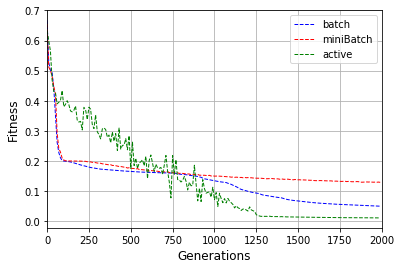

In [21]:
fig = plt.figure()
plt.grid(1)
plt.xlim([0, NUM_EPOCHS])
plt.ion()
plt.xlabel('Generations')
plt.ylabel('Fitness')
plots = []
descriptions = []

things = [[regularisationBatchNets, 'batch'], [regularisationMiniBatchNets, 'miniBatch'], [regularisationActiveNets, 'active']]
for x, graph in enumerate(things):
    
    overTimeAccuracy = np.array(list(map(lambda x: x.trainOverTimeAccuracy, graph[0][3][0])))
    meanOverTimeAccuracy = 1 - np.mean(overTimeAccuracy, axis=0)
    plots.append(plt.plot(generations, meanOverTimeAccuracy, plotColors[x%len(plotColors)] , linewidth=1, markersize=3)[0])
    descriptions.append(graph[1])

plt.legend(plots, descriptions)
fig.savefig('./docs/both2.png')
plt.show(5)

plt.close()